In [2]:
import rasterio
import pandas as pd

# Path to your .tif file
tif_path = "/Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif"

# Open the raster file
with rasterio.open(tif_path) as dataset:
    metadata = {
        "File Path": tif_path,
        "CRS": dataset.crs.to_string() if dataset.crs else "Unknown",
        "Width": dataset.width,
        "Height": dataset.height,
        "Pixel Size X": dataset.transform[0],
        "Pixel Size Y": dataset.transform[4],  # Normally negative (top-left to bottom-right)
        "Number of Bands": dataset.count,
        "Bounds": dataset.bounds
    }

# Convert metadata to DataFrame
df = pd.DataFrame([metadata])

# Show DataFrame
print(df)

# Save to CSV if needed
df.to_csv("raster_metadata.csv", index=False)

                                           File Path  \
0  /Users/baudotedua/Dropbox/Mac/Documents/dati h...   

                                                 CRS  Width  Height  \
0  PROJCS["Unknown_datum_based_upon_the_custom_sp...    565     769   

   Pixel Size X  Pixel Size Y  Number of Bands  \
0    463.312717   -463.312717                1   

                                              Bounds  
0  (-1378818.64438684, 1679971.9101297148, -11170...  


In [127]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from shapely.geometry import shape

# Step 1: Read the shapefile
gdf = gpd.read_file('/Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp')

# Step 2: Define the raster properties
pixel_size = 0.01  # Define pixel size in the same CRS as your shapefile (e.g., 0.01 degrees)
bounds = gdf.total_bounds  # Get the bounds of the shapefile
width = int((bounds[2] - bounds[0]) / pixel_size)  # Calculate the number of pixels along x-axis
height = int((bounds[3] - bounds[1]) / pixel_size)  # Calculate the number of pixels along y-axis

# Step 3: Create a new raster (with the shape of the shapefile)
transform = rasterio.transform.from_origin(bounds[0], bounds[3], pixel_size, pixel_size)

# Rasterize the shapefile (vector to raster)
raster = rasterize(
    [(geom, 1) for geom in gdf.geometry], 
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Step 4: Get coordinates inside each pixel with value 1 (inside the shape)
coordinates = []

# Loop through the raster and get the coordinates for each pixel with a value of 1
for row in range(height):
    for col in range(width):
        if raster[row, col] == 1:  # If the pixel contains part of the shapefile
            # Get the coordinates of the pixel center
            x, y = rasterio.transform.xy(transform, row, col)
            coordinates.append((x, y))

# Display the coordinates
print(coordinates)


[(np.float64(-10.977241397999942), np.float64(18.306542745000055)), (np.float64(-11.047241397999942), np.float64(18.296542745000053)), (np.float64(-11.037241397999942), np.float64(18.296542745000053)), (np.float64(-10.987241397999941), np.float64(18.296542745000053)), (np.float64(-10.977241397999942), np.float64(18.296542745000053)), (np.float64(-11.067241397999942), np.float64(18.286542745000055)), (np.float64(-11.057241397999942), np.float64(18.286542745000055)), (np.float64(-11.047241397999942), np.float64(18.286542745000055)), (np.float64(-11.037241397999942), np.float64(18.286542745000055)), (np.float64(-11.027241397999942), np.float64(18.286542745000055)), (np.float64(-11.007241397999941), np.float64(18.286542745000055)), (np.float64(-10.997241397999941), np.float64(18.286542745000055)), (np.float64(-10.987241397999941), np.float64(18.286542745000055)), (np.float64(-10.977241397999942), np.float64(18.286542745000055)), (np.float64(-11.087241397999941), np.float64(18.2765427450000

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 5: Plot the coordinates using Matplotlib
x_coords, y_coords = zip(*coordinates)  # Unzip the coordinates into two separate lists

# Create a scatter plot of the coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Coordinates Inside Each Pixel of the Shapefile")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


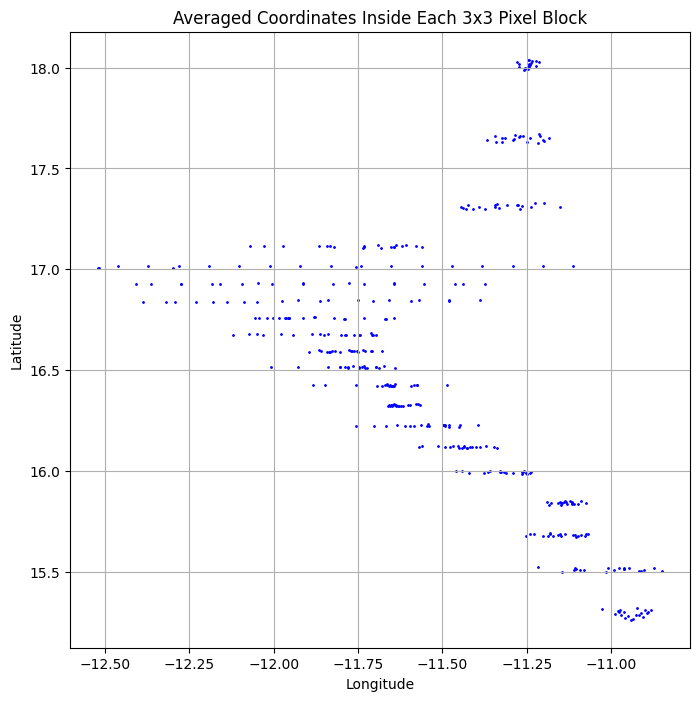

Number of averaged coordinates: 400


In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def average_coordinates(coordinates, grid_size=9):
    """
    Averages coordinates in grid blocks (3x3).
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - grid_size: The grid size for averaging, default is 3 (for 3x3 block).
    
    Returns:
    - List of tuples containing averaged coordinates for each 3x3 block.
    """
    averaged_coords = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the 3x3 block
            block_coords = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        block_coords.append(coordinates[idx])
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                averaged_coords.append((avg_x, avg_y))
    
    return averaged_coords


# Step 3: Average coordinates in 3x3 blocks
averaged_coordinates = average_coordinates(coordinates)

# Step 4: Plot the averaged coordinates using Matplotlib
x_coords, y_coords = zip(*averaged_coordinates)  # Unzip the averaged coordinates into two separate lists

# Create a scatter plot of the averaged coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Averaged Coordinates Inside Each 3x3 Pixel Block")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Optionally, print the number of averaged coordinates
print(f"Number of averaged coordinates: {len(averaged_coordinates)}")


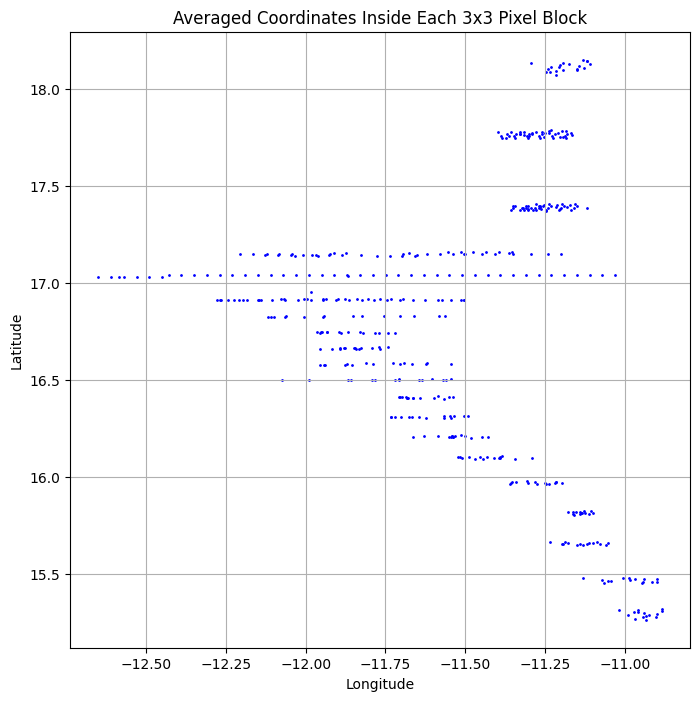

Number of averaged coordinates: 450


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def average_coordinates(coordinates, grid_size=9):
    """
    Averages coordinates in grid blocks (3x3).
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - grid_size: The grid size for averaging, default is 3 (for 3x3 block).
    
    Returns:
    - List of tuples containing averaged coordinates for each 3x3 block.
    """
    averaged_coords = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the 3x3 block
            block_coords = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        # Get the coordinate tuple
                        coord = coordinates[idx]
                        y = coord[1]
                        
                        # Set the grid size conditionally based on y
                        grid_size = 4 if y > 17 else 12

                        # Add coordinate to block
                        block_coords.append(coord)
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                averaged_coords.append((avg_x, avg_y))
    
    return averaged_coords


# Step 3: Average coordinates in 3x3 blocks
averaged_coordinates = average_coordinates(coordinates)

# Step 4: Plot the averaged coordinates using Matplotlib
x_coords, y_coords = zip(*averaged_coordinates)  # Unzip the averaged coordinates into two separate lists

# Create a scatter plot of the averaged coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Averaged Coordinates Inside Each 3x3 Pixel Block")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Optionally, print the number of averaged coordinates
print(f"Number of averaged coordinates: {len(averaged_coordinates)}")


In [9]:
from shapely.geometry import Point, Polygon
import geopandas as gpd

In [10]:
def identify_regions_for_coordinates2(coordinates_list, gdf):
    """
    Identify which regions (polygons) each coordinate belongs to and return a DataFrame.
    Store both ADM3_EN and ADM2_EN for each region.

    :param coordinates_list: A list of 2D tuples or lists [x, y] representing pixel coordinates.
    :param gdf: A GeoDataFrame containing polygons (regions) in the 'geometry' column.
    
    :return: A DataFrame with coordinates as rows and region names (ADM3_EN, ADM2_EN) as columns.
    """
    # Initialize a list to store the results for each coordinate
    result = []

    # Iterate through all coordinates
    for coord in coordinates_list:
        point = Point(coord)  # Convert the pixel coordinates to a Shapely Point object
        regions_belongs_to = []

        # Check which region the point (coordinate) belongs to
        for idx, polygon in enumerate(gdf.geometry):
            if polygon.contains(point):
                # Append both ADM3_EN and ADM2_EN to the list
                regions_belongs_to.append(gdf.iloc[idx]['ADM3_EN'])
                regions_belongs_to.append(gdf.iloc[idx]['ADM2_EN'])

        # Append the result for the current coordinate (either regions or empty if not found)
        result.append(regions_belongs_to)

    # Create a DataFrame with coordinates and the corresponding region names
    # Dynamic column names for ADM3_EN and ADM2_EN
    region_columns = [f"ADM3_{i+1}" for i in range(max(len(r)//2 for r in result))]
    region_columns += [f"ADM2_{i+1}" for i in range(max(len(r)//2 for r in result))]

    # Adjust result so each coordinate is paired with both ADM3_EN and ADM2_EN
    adjusted_result = []
    for regions in result:
        regions_pair = []
        for i in range(0, len(regions), 2):
            regions_pair.append([regions[i], regions[i+1]])
        adjusted_result.append(regions_pair)

    # Flatten the adjusted result for the DataFrame
    flattened_result = []
    for pair in adjusted_result:
        flattened_result.append([item for sublist in pair for item in sublist])

    # Create DataFrame
    df = pd.DataFrame(flattened_result, columns=region_columns)
    
    # Optionally, add the original coordinates to the DataFrame
    df['Coordinates'] = coordinates_list

    return df

In [11]:
dataframe_internal_data = identify_regions_for_coordinates2(coordinates , gdf)

In [ ]:
dataframe_internal_data

------

Adding streamline info 

In [12]:
# Path to the shapefile
streamline_shp_path = "/Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Streamwater_Line_Road_Network/Streamwater.shp"

# Load the shapefile
gdf_streamline = gpd.read_file(streamline_shp_path)

# Access the attribute data (from the .dbf file)
print(gdf_streamline.head())

   FID_1  name name_en waterway covered width depth layer blockage tunnel  \
0   9539  None    None   stream    None  None  None  None     None   None   
1   1639  None    None   stream    None  None  None  None     None   None   
2   2477  None    None     weir    None  None  None  None     None   None   
3   4230  None    None   stream    None  None  None  None     None   None   
4   5242  None    None   stream    None  None  None  None     None   None   

  natural water source name_ar        osm_id   osm_type  \
0    None  None   None    None  1.336799e+09  ways_line   
1    None  None   None    None  6.857615e+08  ways_line   
2    None  None   None    None  4.068417e+08  ways_line   
3    None  None   None    None  4.701723e+08  ways_line   
4    None  None   None    None  4.701723e+08  ways_line   

                                            geometry  
0  LINESTRING (-11.41043 16.48706, -11.40772 16.4...  
1  LINESTRING (-10.89422 15.29227, -10.89333 15.2...  
2  LINESTRING (-1

In [ ]:
gdf_streamline

In [27]:
from shapely.geometry import Point, LineString, MultiLineString

In [32]:
def calculate_distance_to_water(df_points, df_lines):
    """
    Calculate the distance from each point in df_points to all lines in df_lines and store the metric in a new column.
    Then, normalize the 'distance_to_water' column.
    
    :param df_points: DataFrame containing point coordinates in 'coordinates' column (2D vector as a tuple).
    :param df_lines: DataFrame containing LineStrings or MultiLineStrings in the 'geometry' column.
    :return: DataFrame with a new 'distance_to_water' column and normalized distances.
    """
    # Convert line geometries from 'geometry' column in df_lines to shapely LineString or MultiLineString objects
    lines = []
    for geometry in df_lines['geometry']:
        if isinstance(geometry, MultiLineString):
            # If it's a MultiLineString, iterate over the individual LineString geometries
            for line in geometry.geoms:
                lines.append(line)
        elif isinstance(geometry, LineString):
            # If it's a single LineString, add it directly
            lines.append(geometry)
    
    # Define a function to calculate the total distance from a point to all lines
    def total_distance_from_lines(point_coords):
        point = Point(point_coords)  # Convert coordinates to Shapely Point
        total_distance = sum(point.distance(line) for line in lines)
        return total_distance
    
    # Step 1: Calculate the distance from each point to all lines and add it as a new column
    df_points['distance_to_water'] = df_points['Coordinates'].apply(total_distance_from_lines)
    
    # Step 2: Normalize the 'distance_to_water' column using min-max normalization
    min_distance = df_points['distance_to_water'].min()
    max_distance = df_points['distance_to_water'].max()
    df_points['normalized_distance_to_water'] = (df_points['distance_to_water'] - min_distance) / (max_distance - min_distance)
    
    return df_points

In [33]:
dataframe2 = calculate_distance_to_water(dataframe_internal_data, gdf_streamline)

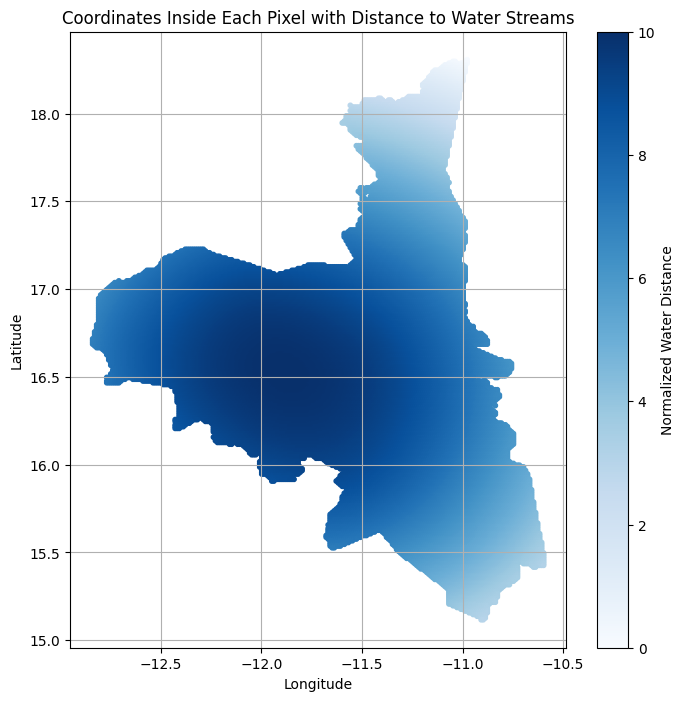

In [37]:
coordinates = dataframe2['Coordinates'].tolist()
normalized_water_distance = dataframe2['normalized_distance_to_water'].tolist()

# Step 2: Unzip the coordinates into x and y values
x_coords, y_coords = zip(*coordinates)  # Unzip the coordinates into two separate lists

# Step 3: Create a scatter plot with color intensity based on normalized_water_distance
plt.figure(figsize=(8, 8))

# Use 'c' to set the color intensity based on normalized_water_distance
# Normalize color values between 0 and 1 for proper scaling in the color map
plt.scatter(x_coords, y_coords, c=(1-np.array(normalized_water_distance))*10, cmap='Blues', s=10)  # s=10 sets the marker size to 10

# Add color bar to indicate the scale of distances
plt.colorbar(label='Normalized Water Distance')

# Add title and labels
plt.title("Coordinates Inside Each Pixel with Distance to Water Streams")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show()

In [38]:
dataframe_internal_data = dataframe2

------

-------

RECOMPILE EVERYTHING 

In [45]:
def identify_regions_for_coordinates2(coordinates_list, gdf):
    """
    Identify which regions (polygons) each coordinate belongs to and return a DataFrame.
    Store both ADM3_EN and ADM2_EN for each region.

    :param coordinates_list: A list of 2D tuples or lists [x, y] representing pixel coordinates.
    :param gdf: A GeoDataFrame containing polygons (regions) in the 'geometry' column.
    
    :return: A DataFrame with coordinates as rows and region names (ADM3_EN, ADM2_EN) as columns.
    """
    # Initialize a list to store the results for each coordinate
    result = []

    # Iterate through all coordinates
    for coord in coordinates_list:
        point = Point(coord)  # Convert the pixel coordinates to a Shapely Point object
        regions_belongs_to = []

        # Check which region the point (coordinate) belongs to
        for idx, polygon in enumerate(gdf.geometry):
            if polygon.contains(point):
                # Append both ADM3_EN and ADM2_EN to the list
                regions_belongs_to.append(gdf.iloc[idx]['ADM3_EN'])
                regions_belongs_to.append(gdf.iloc[idx]['ADM2_EN'])

        # Append the result for the current coordinate (either regions or empty if not found)
        result.append(regions_belongs_to)

    # Create a DataFrame with coordinates and the corresponding region names
    # Dynamic column names for ADM3_EN and ADM2_EN
    region_columns = [f"ADM3_{i+1}" for i in range(max(len(r)//2 for r in result))]
    region_columns += [f"ADM2_{i+1}" for i in range(max(len(r)//2 for r in result))]

    # Adjust result so each coordinate is paired with both ADM3_EN and ADM2_EN
    adjusted_result = []
    for regions in result:
        regions_pair = []
        for i in range(0, len(regions), 2):
            regions_pair.append([regions[i], regions[i+1]])
        adjusted_result.append(regions_pair)

    # Flatten the adjusted result for the DataFrame
    flattened_result = []
    for pair in adjusted_result:
        flattened_result.append([item for sublist in pair for item in sublist])

    # Create DataFrame
    df = pd.DataFrame(flattened_result, columns=region_columns)
    
    # Optionally, add the original coordinates to the DataFrame
    df['Coordinates'] = coordinates_list

    return df

In [47]:
dfprova = identify_regions_for_coordinates2(averaged_coordinates , gdf)

In [48]:
def calculate_distance_to_water(df_points, df_lines):
    """
    Calculate the distance from each point in df_points to all lines in df_lines and store the metric in a new column.
    Then, normalize the 'distance_to_water' column.
    
    :param df_points: DataFrame containing point coordinates in 'coordinates' column (2D vector as a tuple).
    :param df_lines: DataFrame containing LineStrings or MultiLineStrings in the 'geometry' column.
    :return: DataFrame with a new 'distance_to_water' column and normalized distances.
    """
    # Convert line geometries from 'geometry' column in df_lines to shapely LineString or MultiLineString objects
    lines = []
    for geometry in df_lines['geometry']:
        if isinstance(geometry, MultiLineString):
            # If it's a MultiLineString, iterate over the individual LineString geometries
            for line in geometry.geoms:
                lines.append(line)
        elif isinstance(geometry, LineString):
            # If it's a single LineString, add it directly
            lines.append(geometry)
    
    # Define a function to calculate the total distance from a point to all lines
    def total_distance_from_lines(point_coords):
        point = Point(point_coords)  # Convert coordinates to Shapely Point
        total_distance = sum(point.distance(line) for line in lines)
        return total_distance
    
    # Step 1: Calculate the distance from each point to all lines and add it as a new column
    df_points['distance_to_water'] = df_points['Coordinates'].apply(total_distance_from_lines)
    
    # Step 2: Normalize the 'distance_to_water' column using min-max normalization
    min_distance = df_points['distance_to_water'].min()
    max_distance = df_points['distance_to_water'].max()
    df_points['normalized_distance_to_water'] = (df_points['distance_to_water'] - min_distance) / (max_distance - min_distance)
    
    return df_points

In [49]:
dfprova = calculate_distance_to_water(dfprova , gdf_streamline)

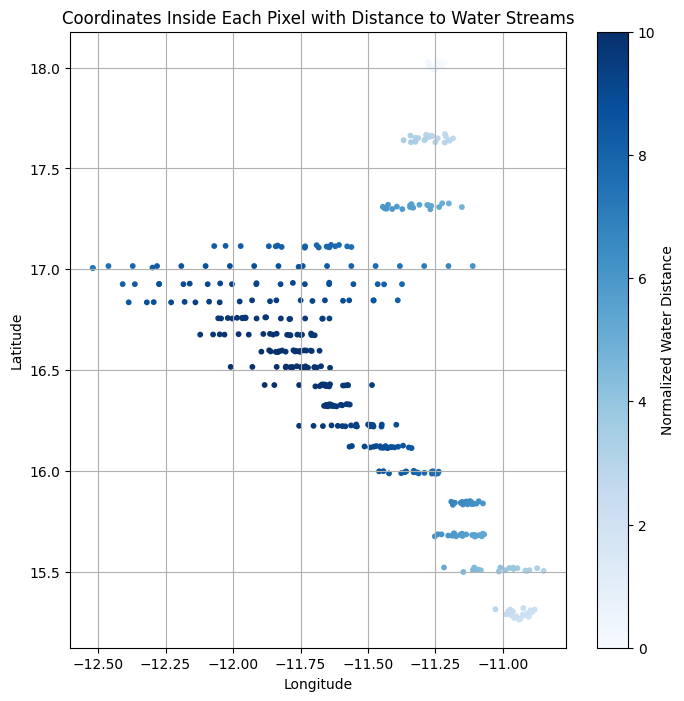

In [50]:
coordinates = dfprova['Coordinates'].tolist()
normalized_water_distance = dfprova['normalized_distance_to_water'].tolist()

# Step 2: Unzip the coordinates into x and y values
x_coords, y_coords = zip(*coordinates)  # Unzip the coordinates into two separate lists

# Step 3: Create a scatter plot with color intensity based on normalized_water_distance
plt.figure(figsize=(8, 8))

# Use 'c' to set the color intensity based on normalized_water_distance
# Normalize color values between 0 and 1 for proper scaling in the color map
plt.scatter(x_coords, y_coords, c=(1-np.array(normalized_water_distance))*10, cmap='Blues', s=10)  # s=10 sets the marker size to 10

# Add color bar to indicate the scale of distances
plt.colorbar(label='Normalized Water Distance')

# Add title and labels
plt.title("Coordinates Inside Each Pixel with Distance to Water Streams")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show()

In [51]:
df = dfprova

-----

distance from roads

In [56]:
def calculate_distance_to_whole_lines(df_points, df_lines):
    """
    Calculate the minimum distance from each point in df_points to the whole set of LineStrings and MultiLineStrings
    in df_lines, and store the distance in a new column 'distance_to_whole_line'.
    
    Args:
    - df_points: DataFrame containing point coordinates in 'Coordinates' column.
    - df_lines: DataFrame containing line geometries (LineString or MultiLineString) in 'geometry' column.
    
    Returns:
    - DataFrame with a new 'distance_to_whole_line' column containing the minimum distance of each point from the lines.
    """
    
    # Create a list of all coordinates from the geometries (both LineString and MultiLineString)
    all_lines = []
    for geometry in df_lines['geometry']:
        if isinstance(geometry, MultiLineString):
            # Flatten the MultiLineString into individual LineStrings using .geoms
            all_lines.extend(geometry.geoms)  # geometry.geoms returns a list of LineString objects
        elif isinstance(geometry, LineString):
            # Single LineString, add it directly
            all_lines.append(geometry)
    
    # Combine all the LineStrings into one MultiLineString (or just keep them as a list of individual LineStrings)
    # Calculate the minimum distance from each point to the closest line in all_lines
    def calculate_min_distance_to_lines(point_coords):
        point = Point(point_coords)  # Convert point to a Shapely Point object
        min_distance = float('inf')  # Initialize with a large value
        
        for line in all_lines:
            distance = point.distance(line)  # Calculate the distance to each line
            min_distance = min(min_distance, distance)  # Keep track of the minimum distance
        
        return min_distance

    # Apply the distance calculation for each point and store the result in a new column
    df_points['distance_to_whole_line'] = df_points['Coordinates'].apply(calculate_min_distance_to_lines)
    
    return df_points

In [53]:
# Path to the shapefile
mainroad_shp_path = "/Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Streamwater_Line_Road_Network/Main_Road.shp"

# Load the shapefile
gdf_mainroad = gpd.read_file(mainroad_shp_path)

# Access the attribute data (from the .dbf file)
print(gdf_mainroad.head())

    ID_                NAME1_  TYPE       LONG  \
0  RNB5   Sangrava - Letvetar     1   21155.67   
1  RNB5  Letvetar - Moudjeria     1   23623.56   
2  RNB1       Boutilimit-Aleg     1   93970.39   
3  RNB3        NKTT - Akjoujt     1  262372.09   
4  RNB2          NKTT - Rosso     1  197195.24   

                                            geometry  
0  LINESTRING (-12.646 17.64222, -12.62673 17.649...  
1  LINESTRING (-12.3329 17.87742, -12.33913 17.88...  
2  LINESTRING (-14.6988 17.5259, -14.6623 17.5238...  
3  MULTILINESTRING ((-15.82551 18.47119, -15.8173...  
4  LINESTRING (-15.96518 18.07919, -15.96914 18.0...  


In [57]:
dfprova = calculate_distance_to_whole_lines(df , gdf_mainroad)

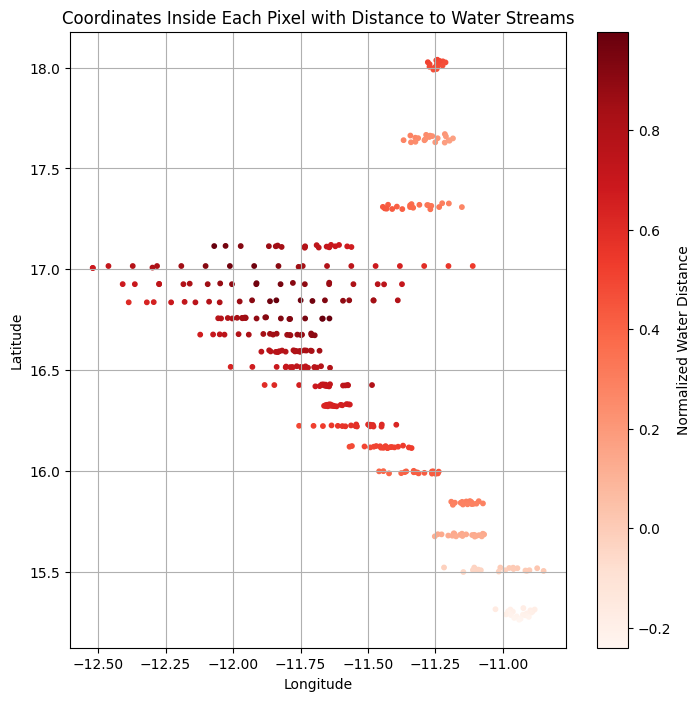

In [60]:
coordinates = dfprova['Coordinates'].tolist()
normalized_water_distance = dfprova['distance_to_whole_line'].tolist()

# Step 2: Unzip the coordinates into x and y values
x_coords, y_coords = zip(*coordinates)  # Unzip the coordinates into two separate lists

# Step 3: Create a scatter plot with color intensity based on normalized_water_distance
plt.figure(figsize=(8, 8))

# Use 'c' to set the color intensity based on normalized_water_distance
# Normalize color values between 0 and 1 for proper scaling in the color map
plt.scatter(x_coords, y_coords, c=(1-np.array(normalized_water_distance)), cmap='Reds', s=10)  # s=10 sets the marker size to 10

# Add color bar to indicate the scale of distances
plt.colorbar(label='Normalized Water Distance')

# Add title and labels
plt.title("Coordinates Inside Each Pixel with Distance to Water Streams")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
df = dfprova
df

In [146]:
#crea piclle con df
import pandas as pd

# Supponiamo che il tuo DataFrame si chiami 'df'
# Salva il DataFrame in un file pickle
df.to_pickle("df.pkl")

# Per caricare il DataFrame dal file pickle
df = pd.read_pickle("df.pkl")

-------

-----

------

Now let's store data about climate precipitation

In [147]:

# Define the path to the .tif file
tif_path = '/Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Climate_Precipitation_Data/2010R.tif'

# Open the .tif file using rasterio
with rasterio.open(tif_path) as src:
    # Read the image data (first band)
    image_data = src.read(1)

# Convert the image data to a pandas DataFrame
precipitation_data = pd.DataFrame(image_data)

In [148]:
precipitation_data

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
1,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,1.215817e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
2,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,1.228431e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
3,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,1.270130e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
4,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,1.242941e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,4.605452e+02,4.536997e+02,4.617298e+02,4.497101e+02,4.620845e+02,4.808761e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
61,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,4.679947e+02,4.627641e+02,4.773564e+02,4.680056e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
62,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,4.647834e+02,4.683933e+02,4.808802e+02,4.875965e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38
63,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,...,-3.402823e+38,4.756503e+02,4.897948e+02,4.941135e+02,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38


DIFFICULT TO READ AND DETECT -> PLUS, WE DOWNLOADED THE PRECIPITATION DATA FROM NASA WEBSITE, SO WE SHOULD BE FINE -> CHECK IF THEY COINCIDE 

-----

-----

In [152]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import xml.etree.ElementTree as ET

def read_aux_xml(tif_path):
    """
    Legge il file ausiliario (.tif.aux.xml) associato a tif_path e restituisce un dizionario con le statistiche.
    """
    aux_path = tif_path + ".aux.xml"
    stats = {}
    if os.path.exists(aux_path):
        try:
            tree = ET.parse(aux_path)
            root = tree.getroot()
            # Cerca i nodi <MDI> all'interno di <Metadata>
            for mdi in root.findall(".//Metadata/MDI"):
                key = mdi.get("key")
                value = mdi.text.strip() if mdi.text is not None else ""
                stats[key] = value
        except Exception as e:
            print(f"❌ Errore nella lettura di {aux_path}: {e}")
    return stats


In [153]:
def extract_coordinates_with_data(folder_path):
    """
    Iterates over all .tif files in folder_path, extracting coordinates and corresponding valid_data values.
    Returns a dictionary where each key is a filename, and the value is a DataFrame with coordinates and data values.
    
    :param folder_path: Path to the folder containing .tif files
    :return: Dictionary {filename: DataFrame(columns=['Longitude', 'Latitude', 'Value'])}
    """
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.tif')]
    if not tif_files:
        print(f"❌ No .tif files found in: {folder_path}")
        return {}
    
    tif_files.sort()
    results = {}
    
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        print(f"\n📂 Processing: {tif_path}")
        
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1)  # Read first band
                transform = src.transform  # Get affine transformation
                
                # Apply NoData mask if defined
                if src.nodata is not None:
                    data = np.ma.masked_array(data, mask=(data == src.nodata))
                
                rows, cols = data.shape
                coords = []
                values = []
                
                for row in range(rows):
                    for col in range(cols):
                        if not np.ma.is_masked(data[row, col]):  # Consider only valid values
                            lon, lat = rasterio.transform.xy(transform, row, col)
                            coords.append((lon, lat))
                            values.append(data[row, col])
                
                # Create DataFrame
                df = pd.DataFrame(coords, columns=['Longitude', 'Latitude'])
                df['Value'] = values
                results[tif_file] = df
                
        except Exception as e:
            print(f"❌ Error processing {tif_file}: {e}")
    
    return results

In [154]:
folder_path = '/Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data'

In [155]:
dictionary = extract_coordinates_with_data(folder_path)


📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2011LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2012LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2013LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2014LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2015LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2016LCT.tif

📂 Processing: /Users/baudotedua/Dropbox/Mac/Documents/dati hackathon/Datasets_Hackathon/Modis_Land_Cover_Data/2017LCT.tif

📂 Processing: /

Let's take the first file and create a dataframe

In [156]:
value = dictionary["2010LCT.tif"]

# Convert the value (a list of lists) into a DataFrame
dfprovaprova = pd.DataFrame(value, columns=["Longitude", "Latitude", "Value"])

In [157]:
dfprovaprova

,Longitude,Latitude,Value
0,-1.158513e+06,2.036028e+06,16
1,-1.158977e+06,2.035564e+06,16
2,-1.158513e+06,2.035564e+06,16
3,-1.159440e+06,2.035101e+06,16
4,-1.158977e+06,2.035101e+06,16
...,...,...,...
168207,-1.169170e+06,1.681130e+06,10
168208,-1.170560e+06,1.680667e+06,10
168209,-1.170096e+06,1.680667e+06,10
168210,-1.169633e+06,1.680667e+06,10


In [158]:
from pyproj import CRS, Transformer

def transform_coordinates(x, y):
    """
    Transforms coordinates from the Sinusoidal projection to WGS 84 (Latitude/Longitude).
    
    :param x: Easting (X-coordinate) in Sinusoidal projection
    :param y: Northing (Y-coordinate) in Sinusoidal projection
    :return: A tuple containing the latitude and longitude in WGS 84
    """
    # Define the Sinusoidal projection based on the PROJ4 parameters
    src_crs = CRS.from_proj4('+proj=sinu +a=6371007.181 +b=6371007.181 +units=m')

    # Define the target CRS for WGS 84 (Latitude/Longitude)
    dst_crs = CRS("EPSG:4326")  # WGS 84 (Latitude/Longitude)

    # Create a transformer object to convert between CRS
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

    # Convert the given coordinates from Sinusoidal to Latitude/Longitude
    lon, lat = transformer.transform(x, y)

    return lat, lon


In [159]:
dfprovaprova2 = dfprovaprova.head(1000)


Let's transform all the coordinates values -> it takes too much to run

In [160]:
dfprovaprova2[['Latitude', 'Longitude']] = dfprovaprova2.apply(
    lambda row: pd.Series(transform_coordinates(row['Latitude'], row['Longitude'])), axis=1
)

/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_4770/723959758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfprovaprova2[['Latitude', 'Longitude']] = dfprovaprova2.apply(


-----

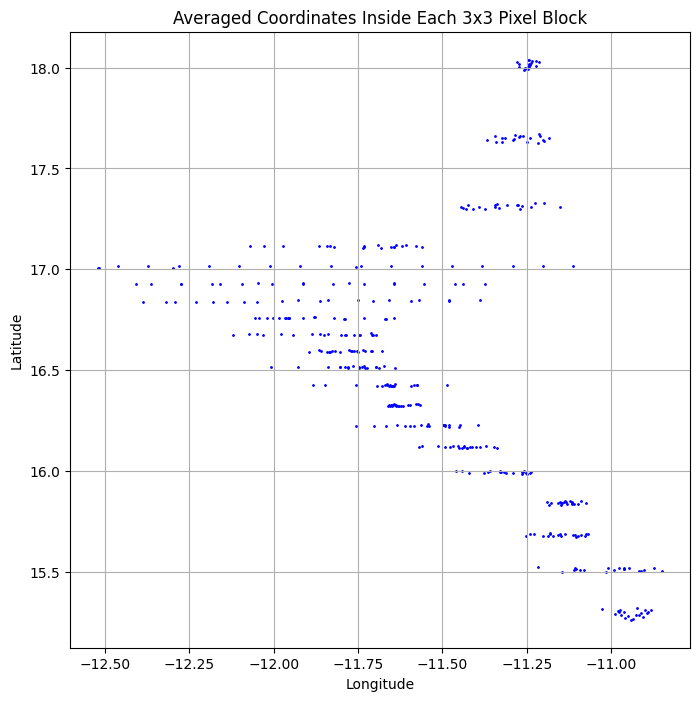

Number of averaged coordinates: 400


In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def average_coordinates(coordinates, grid_size=9):
    """
    Averages coordinates in grid blocks (3x3).
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - grid_size: The grid size for averaging, default is 3 (for 3x3 block).
    
    Returns:
    - List of tuples containing averaged coordinates for each 3x3 block.
    """
    averaged_coords = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the 3x3 block
            block_coords = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        block_coords.append(coordinates[idx])
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                averaged_coords.append((avg_x, avg_y))
    
    return averaged_coords


# Step 3: Average coordinates in 3x3 blocks
averaged_coordinates = average_coordinates(coordinates)

# Step 4: Plot the averaged coordinates using Matplotlib
x_coords, y_coords = zip(*averaged_coordinates)  # Unzip the averaged coordinates into two separate lists

# Create a scatter plot of the averaged coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Averaged Coordinates Inside Each 3x3 Pixel Block")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Optionally, print the number of averaged coordinates
print(f"Number of averaged coordinates: {len(averaged_coordinates)}")


In [162]:
dfprovaprova['coordinate'] = list(zip(dfprovaprova['Longitude'], dfprovaprova['Latitude']))


-----

In [163]:
PORCODIO = averaged_coordinates

In [164]:
df_porcodio= pd.DataFrame(PORCODIO, columns=['0', '1'])

# Rename the columns to 'longitude' and 'latitude'
df_porcodio.rename(columns={'0': 'longitude', '1': 'latitude'}, inplace=True)

In [173]:
dfprova666=df
dfprova666

,ADM3_1,ADM2_1,Coordinates,distance_to_water,normalized_distance_to_water,distance_to_whole_line,x,y
0,Lavtah,Boumdeid,"(-11.242796953555496, 18.03901188080252)",1042.156048,0.999908,0.496945,-1.188694e+06,2.005849e+06
1,Lavtah,Boumdeid,"(-11.246747570839446, 18.035925461049434)",1039.812464,0.996243,0.496833,-1.189132e+06,2.005506e+06
2,Lavtah,Boumdeid,"(-11.235142632567843, 18.033209411666718)",1040.779365,0.997755,0.506298,-1.187924e+06,2.005204e+06
3,Lavtah,Boumdeid,"(-11.222673496765372, 18.030987189444495)",1042.214916,1.000000,0.516054,-1.186620e+06,2.004957e+06
4,Lavtah,Boumdeid,"(-11.278105595530807, 18.026666201790174)",1029.004534,0.979341,0.484599,-1.192511e+06,2.004476e+06
...,...,...,...,...,...,...,...,...
395,Tenaha,Kankoussa,"(-10.94890806466661, 15.279876078333384)",896.966464,0.772850,1.225741,-1.174427e+06,1.699047e+06
396,Tenaha,Kankoussa,"(-10.903908064666608, 15.277653856111161)",912.063418,0.796460,1.221271,-1.169613e+06,1.698800e+06
397,Tenaha,Kankoussa,"(-10.958074731333276, 15.272376078333386)",897.382522,0.773501,1.230040,-1.175452e+06,1.698213e+06
398,Tenaha,Kankoussa,"(-10.934463620222168, 15.268764967222275)",906.191615,0.787277,1.234413,-1.172940e+06,1.697811e+06


In [ ]:
import pandas as pd
from pyproj import CRS, Transformer

# Esempio di DataFrame con coordinate radiali nella colonna 'Coordinates'


# Funzione per trasformare le coordinate
def inverse_transform_coordinates(lat, lon):
    """
    Transforms coordinates from WGS 84 (Latitude/Longitude) to Sinusoidal projection.
    """
    src_crs = CRS("EPSG:4326")  # WGS 84 (Latitude/Longitude)
    dst_crs = CRS.from_proj4('+proj=sinu +a=6371007.181 +b=6371007.181 +units=m')
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    x, y = transformer.transform(lon, lat)  # Nota: ordine lon, lat
    return x, y



# Applica la funzione al DataFrame
dfprova666[['x', 'y']] = dfprova666['Coordinates'].apply(
    lambda coord: pd.Series(inverse_transform_coordinates(coord[1], coord[0]))  # Inverti lat e lon
)

# Visualizza il risultato
print(dfprova666)

     ADM3_1     ADM2_1                                Coordinates  \
0    Lavtah   Boumdeid   (-11.242796953555496, 18.03901188080252)   
1    Lavtah   Boumdeid  (-11.246747570839446, 18.035925461049434)   
2    Lavtah   Boumdeid  (-11.235142632567843, 18.033209411666718)   
3    Lavtah   Boumdeid  (-11.222673496765372, 18.030987189444495)   
4    Lavtah   Boumdeid  (-11.278105595530807, 18.026666201790174)   
..      ...        ...                                        ...   
395  Tenaha  Kankoussa   (-10.94890806466661, 15.279876078333384)   
396  Tenaha  Kankoussa  (-10.903908064666608, 15.277653856111161)   
397  Tenaha  Kankoussa  (-10.958074731333276, 15.272376078333386)   
398  Tenaha  Kankoussa  (-10.934463620222168, 15.268764967222275)   
399  Tenaha  Kankoussa  (-10.939741397999942, 15.263487189444497)   

     distance_to_water  normalized_distance_to_water  distance_to_whole_line  \
0          1042.156048                      0.999908                0.496945   
1          

In [ ]:
dfprova666

In [ ]:
df_porcodio[['latnew', 'longnew']] = df_porcodio.apply(
    lambda row: pd.Series(inverse_transform_coordinates(row['latitude'], row['longitude'])), axis=1
)

In [138]:
porcamadonna = df_porcodio[['latnew', 'longnew']]

# Convert each row into a tuple (latitude, longitude) and create a list of unique tuples
unique_coordinates = list(set(tuple(row) for row in porcamadonna.values))

In [139]:
unique_coordinates[0]

(np.float64(-1242406.9916089575), np.float64(1825932.524038223))

In [141]:
filtered_df = dfprovaprova[dfprovaprova['coordinate'].isin(unique_coordinates)]


----

In [178]:
dfprovaprova = dfprovaprova.drop(dfprovaprova.sample(n=8212, random_state=42).index)

In [180]:
coordinates_parte2 = dfprovaprova['coordinate'].tolist()

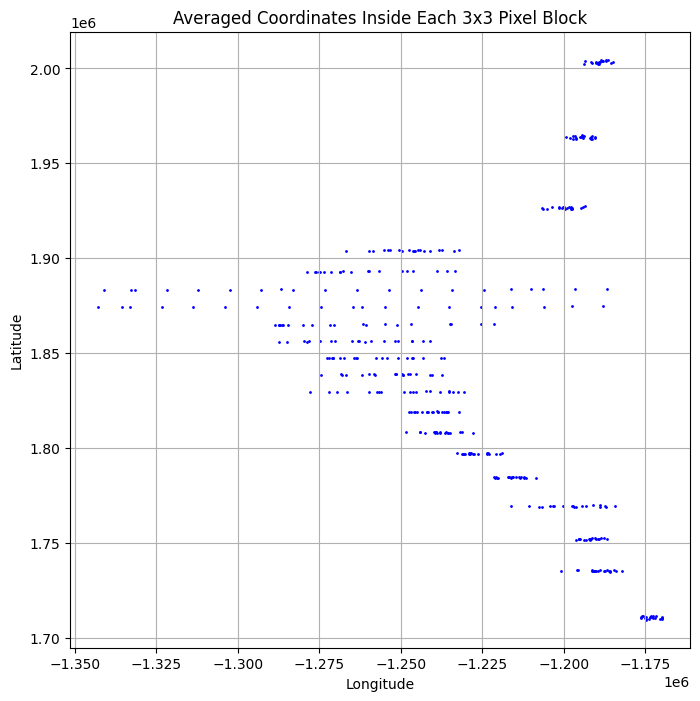

Number of averaged coordinates: 400


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def average_coordinates(coordinates, grid_size=20):
    """
    Averages coordinates in grid blocks (3x3).
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - grid_size: The grid size for averaging, default is 3 (for 3x3 block).
    
    Returns:
    - List of tuples containing averaged coordinates for each 3x3 block.
    """
    averaged_coords = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the 3x3 block
            block_coords = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        block_coords.append(coordinates[idx])
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                averaged_coords.append((avg_x, avg_y))
    
    return averaged_coords


# Step 3: Average coordinates in 3x3 blocks
averaged_coordinates_2 = average_coordinates(coordinates_parte2)

# Step 4: Plot the averaged coordinates using Matplotlib
x_coords, y_coords = zip(*averaged_coordinates_2)  # Unzip the averaged coordinates into two separate lists

# Create a scatter plot of the averaged coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Averaged Coordinates Inside Each 3x3 Pixel Block")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Optionally, print the number of averaged coordinates
print(f"Number of averaged coordinates: {len(averaged_coordinates)}")


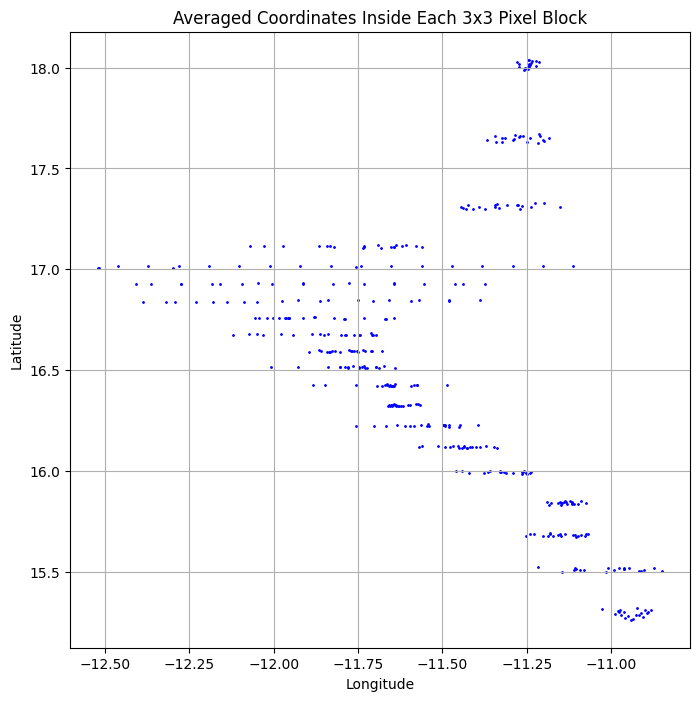

Number of averaged coordinates: 400


In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def average_coordinates(coordinates, grid_size=9):
    """
    Averages coordinates in grid blocks (3x3).
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - grid_size: The grid size for averaging, default is 3 (for 3x3 block).
    
    Returns:
    - List of tuples containing averaged coordinates for each 3x3 block.
    """
    averaged_coords = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the 3x3 block
            block_coords = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        block_coords.append(coordinates[idx])
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                averaged_coords.append((avg_x, avg_y))
    
    return averaged_coords


# Step 3: Average coordinates in 3x3 blocks
averaged_coordinates = average_coordinates(coordinates)

# Step 4: Plot the averaged coordinates using Matplotlib
x_coords, y_coords = zip(*averaged_coordinates)  # Unzip the averaged coordinates into two separate lists

# Create a scatter plot of the averaged coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Averaged Coordinates Inside Each 3x3 Pixel Block")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Optionally, print the number of averaged coordinates
print(f"Number of averaged coordinates: {len(averaged_coordinates)}")


In [187]:
from scipy.spatial import cKDTree

In [190]:
def average_coordinates_with_value(coordinates, values, grid_size=20):
    """
    Averages coordinates in grid blocks (grid_size x grid_size) and assigns the corresponding 'Value'
    to each averaged coordinate.
    
    Args:
    - coordinates: List of tuples (x, y) representing coordinates.
    - values: List of 'Value' corresponding to the coordinates.
    - grid_size: The grid size for averaging, default is 20 (for 20x20 block).
    
    Returns:
    - A DataFrame containing the averaged coordinates and their corresponding 'Value'.
    """
    averaged_coords = []
    averaged_values = []
    
    # We assume coordinates are sorted in the same way as a raster
    num_rows = int(np.sqrt(len(coordinates)))  # Assuming square raster (rows == cols)
    
    for row in range(0, num_rows, grid_size):
        for col in range(0, num_rows, grid_size):
            # Get the coordinates within the grid block
            block_coords = []
            block_values = []
            
            for i in range(grid_size):
                for j in range(grid_size):
                    idx = (row + i) * num_rows + (col + j)  # Index in the flat list of coordinates
                    if idx < len(coordinates):  # Ensure it's within bounds
                        block_coords.append(coordinates[idx])
                        block_values.append(values[idx])
            
            # Calculate the average of x and y in the block
            if block_coords:
                avg_x = np.mean([coord[0] for coord in block_coords])
                avg_y = np.mean([coord[1] for coord in block_coords])
                
                # Find the closest original coordinate to the averaged coordinate
                tree = cKDTree(block_coords)
                dist, idx = tree.query((avg_x, avg_y))  # Get the closest original coordinate
                
                # Append the averaged coordinate and its corresponding 'Value'
                averaged_coords.append((avg_x, avg_y))
                averaged_values.append(block_values[idx])
    
    # Return the DataFrame with averaged coordinates and corresponding 'Value'
    df_averaged = pd.DataFrame(averaged_coords, columns=['longitude', 'latitude'])
    df_averaged['Value'] = averaged_values
    
    return df_averaged

In [196]:
averaged_df = average_coordinates_with_value(dfprovaprova['coordinate'].tolist(), dfprovaprova['Value'].tolist(), grid_size=20)


In [197]:
def transform_coordinates(x, y):
    """
    Transforms coordinates from the Sinusoidal projection to WGS 84 (Latitude/Longitude).
    
    :param x: Easting (X-coordinate) in Sinusoidal projection
    :param y: Northing (Y-coordinate) in Sinusoidal projection
    :return: A tuple containing the latitude and longitude in WGS 84
    """
    # Define the Sinusoidal projection based on the PROJ4 parameters
    src_crs = CRS.from_proj4('+proj=sinu +a=6371007.181 +b=6371007.181 +units=m')

    # Define the target CRS for WGS 84 (Latitude/Longitude)
    dst_crs = CRS("EPSG:4326")  # WGS 84 (Latitude/Longitude)

    # Create a transformer object to convert between CRS
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

    # Convert the given coordinates from Sinusoidal to Latitude/Longitude
    lon, lat = transformer.transform(x, y)

    return lat, lon

In [199]:
averaged_df[['newlong','newlat']] = averaged_df.apply(
    lambda row: pd.Series(transform_coordinates(row['latitude'], row['longitude'])), axis=1
)

In [210]:
import numpy as np

def euclidean_distance(coord1, coord2):
    """
    Calcola la distanza euclidea tra due coordinate (longitude, latitude).
    
    Args:
    - coord1: La prima coordinata (longitude, latitude).
    - coord2: La seconda coordinata (longitude, latitude).
    
    Returns:
    - La distanza euclidea tra le due coordinate.
    """
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def add_nearest_coordinate(df, coordinate_list):
    """
    Per ogni coordinata nel dataframe, trova la coordinata più vicina dalla lista di coordinate
    e aggiungi la corrispondente coordinata nel dataframe. Ogni coordinata della lista viene
    utilizzata una sola volta.
    
    Args:
    - df: DataFrame contenente le colonne 'longitude' e 'latitude'.
    - coordinate_list: Lista di tuple 2D contenente le coordinate da cui cercare la più vicina.
    
    Returns:
    - Il DataFrame con la colonna 'coordinate' aggiunta.
    """
    # Lista che tiene traccia delle coordinate già usate
    used_coordinates = []
    
    # Funzione per trovare la coordinata più vicina per ogni riga del DataFrame
    def find_nearest(row):
        coord = (row['newlong'], row['newlat'])
        
        # Trova la coordinata più vicina usando la distanza euclidea
        min_dist = float('inf')
        nearest_coord = None
        nearest_idx = -1
        
        for idx, available_coord in enumerate(coordinate_list):
            dist = euclidean_distance(coord, available_coord)
            if dist < min_dist:
                min_dist = dist
                nearest_coord = available_coord
                nearest_idx = idx
        
        # Rimuovi la coordinata dal set di coordinate disponibili
        coordinate_list.pop(nearest_idx)
        
        return nearest_coord
    
    # Applica la funzione find_nearest a ogni riga del DataFrame
    df['coordinate'] = df.apply(find_nearest, axis=1)
    
    return df

In [211]:
porcodio = add_nearest_coordinate(averaged_df, averaged_coordinates)

In [212]:
porcodio = porcodio[['coordinate', 'Value']]


In [213]:
porcodio = porcodio.rename(columns={'Value': 'value2010'})


In [ ]:
porcodio

----

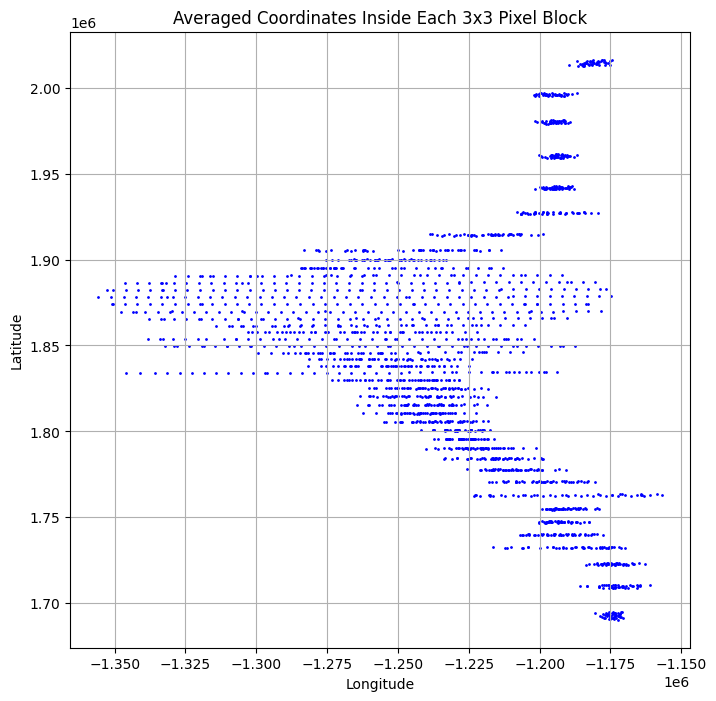

Number of averaged coordinates: 0


In [231]:
value = dictionary["2023LCT.tif"]

# Convert the value (a list of lists) into a DataFrame
dfprovaprova = pd.DataFrame(value, columns=["Longitude", "Latitude", "Value"])

dfprovaprova = dfprovaprova.drop(dfprovaprova.sample(n=8212, random_state=42).index)
dfprovaprova['coordinate'] = list(zip(dfprovaprova['Longitude'], dfprovaprova['Latitude']))

coordinates_parte2 = dfprovaprova['coordinate'].tolist()

# Step 3: Average coordinates in 3x3 blocks
averaged_coordinates_2 = average_coordinates(coordinates_parte2)

# Step 4: Plot the averaged coordinates using Matplotlib
x_coords, y_coords = zip(*averaged_coordinates_2)  # Unzip the averaged coordinates into two separate lists

# Create a scatter plot of the averaged coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', s=1)  # s=1 sets the marker size to 1
plt.title("Averaged Coordinates Inside Each 3x3 Pixel Block")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Optionally, print the number of averaged coordinates
print(f"Number of averaged coordinates: {len(averaged_coordinates)}")

averaged_df = average_coordinates_with_value(dfprovaprova['coordinate'].tolist(), dfprovaprova['Value'].tolist(), grid_size=20)
averaged_df[['newlong','newlat']] = averaged_df.apply(
    lambda row: pd.Series(transform_coordinates(row['latitude'], row['longitude'])), axis=1
)
averaged_coordinates = average_coordinates(coordinates)

porcodio = add_nearest_coordinate(averaged_df, averaged_coordinates)
porcodio = porcodio[['coordinate', 'Value']]
porcodio2023 = porcodio.rename(columns={'Value': 'value2023'})



In [ ]:
porcodio2012

In [214]:
merged_df = porcodio



In [232]:
# Iterate over the other dataframes to merge them on the 'coordinate' column
for df in [porcodio2011, porcodio2012, porcodio2013,porcodio2014, porcodio2015, porcodio2016,porcodio2017, porcodio2018, porcodio2019,porcodio2020, porcodio2021, porcodio2022,porcodio2023]:  # replace df2, df3, df4 with your actual dataframes
    merged_df = pd.merge(merged_df, df, on='coordinate', how='outer')

In [234]:
diocanone = merged_df

In [233]:
df = pd.read_pickle("df.pkl")

In [235]:
df = df.rename(columns={'Coordinates': 'coordinate'})
final_df = pd.merge(merged_df, df, on='coordinate', how='outer', suffixes=('_left', '_right'))



In [ ]:
final_df

------

------

In [236]:
final_df.to_pickle("final_df.pkl")

# Per caricare il DataFrame dal file pickle
df = pd.read_pickle("final_df.pkl")

In [ ]:
df